In [1]:
# display inline plots
%matplotlib inline

# import libraries for numerical and scientific computing
import numpy as np

# import matplotlib for plotting
import matplotlib.pyplot as plt

# import pandas for data wrangling and munging
import pandas as pd

# set some options for better view
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# import plotting library built on top of matplotlib
import seaborn as sns

# set some settings related to style of plots that will render
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')

C:\Users\Abhishek\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from utils import load_data_set, lowercase_column_names
from eval import eval_models

In [3]:
train, test = load_data_set()
train, test = lowercase_column_names(train, test)

Loading datasets
Set ID as index


## Shape of the datasets

In [4]:
print 'Training data set {} and Test data set {}'.format(train.shape, test.shape)

Training data set (3998, 37) and Test data set (1500, 37)


## Feature preparation

In [5]:
specialization_map = {
    'computer engineering': 'computer science',
    'computer science & engineering': 'computer science',
    'computer application': 'computer science',
    'computer science and technology': 'computer science',
    'computer and communication engineering': 'computer science',
    'computer networking': 'computer science',
    'electronics': 'electronics and communication engineering',
    'electronics engineering': 'electronics and communication engineering'
}

def preprocess_specialization(specialization):
    if specialization in specialization_map:
        return specialization_map[specialization]
    else:
        return specialization

train['specialization'] = train.specialization.map(preprocess_specialization)
test['specialization'] = test.specialization.map(preprocess_specialization)

In [6]:
from features import FeatureTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_regression

## Features and Target variable

In [7]:
from sklearn.cross_validation import train_test_split

In [8]:
X = train[train.columns.drop('salary')]
y = train.salary

## Split into training and test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

## Linear Regression

In [10]:
ft = FeatureTransformer(train, test)
sel = SelectKBest(f_regression, k=10)
scaler = StandardScaler()
lm = LinearRegression()

In [11]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('lm', lm)])

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001C95F278>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [13]:
lm_comp = pipeline.get_params()['lm']

In [14]:
print 'Estimated intercept coefficient:', lm_comp.intercept_

Estimated intercept coefficient: 306946.216385


In [15]:
print 'Number of coefficients:', len(lm_comp.coef_)

Number of coefficients: 10


In [16]:
feature_names = pipeline.get_params()['transformer'].get_feature_names()

In [17]:
# The coefficients
pd.DataFrame(zip(feature_names, lm_comp.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,year_of_birth,-20653.505632
1,gender,15070.153990
2,degree,-25928.438857
3,specialization,24444.682890
4,collegestate,-24814.883419
5,10percentage,10977.498696
6,12graduation,-11909.089430
7,12percentage,14774.136057
8,collegeid,9656.975839
9,collegetier,18496.217841


In [18]:
# lets take a look at first five predicted values
pipeline.predict(X_train)[0:5]

array([ 317113.09424033,  396277.80340078,  272066.01596639,
        470774.00038848,  192688.56945305])

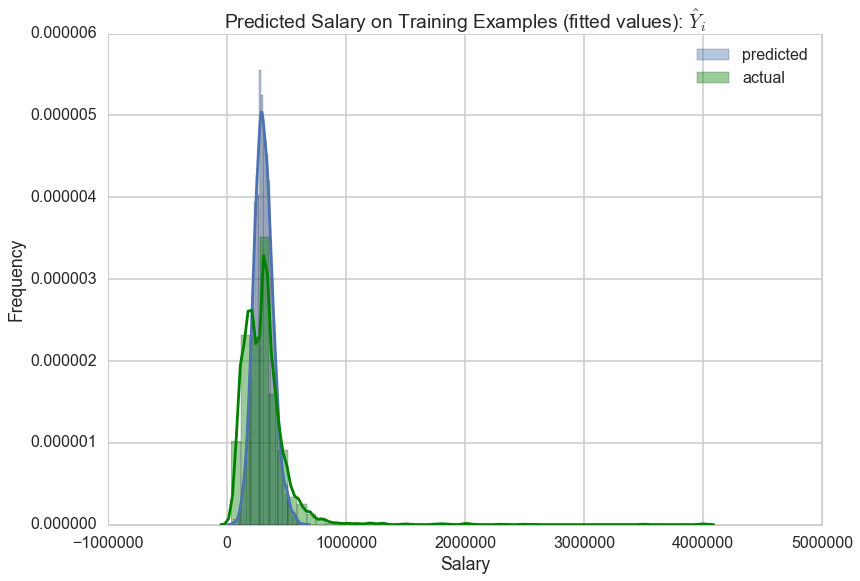

In [19]:
sns.distplot(pipeline.predict(X_train), label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

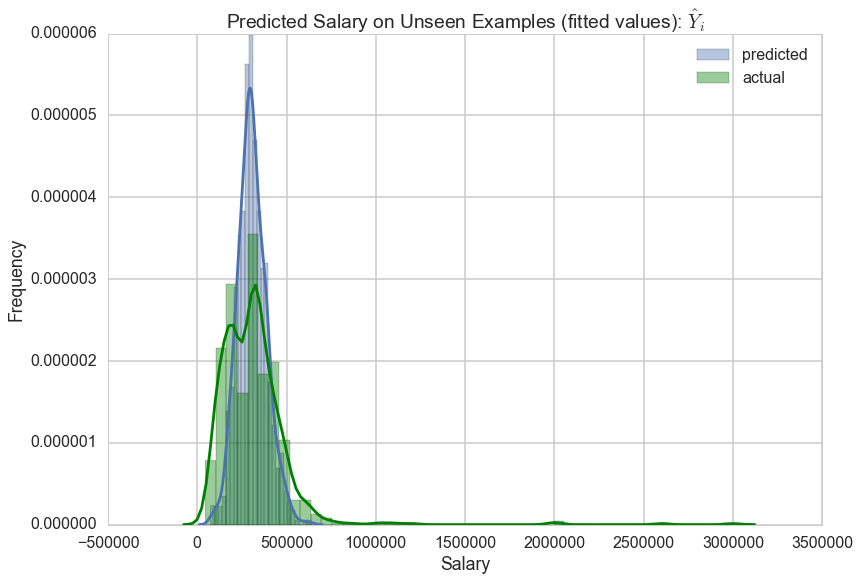

In [20]:
sns.distplot(pipeline.predict(X_test), label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [21]:
pred_comparison_train = pd.DataFrame(zip(y_train, pipeline.predict(X_train)), columns=['actual', 'predicted'])

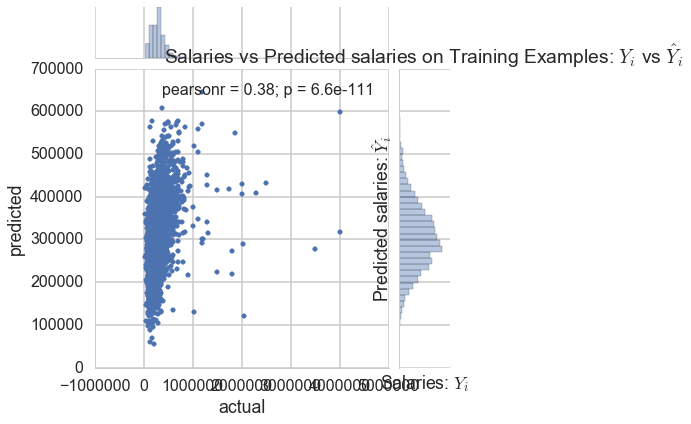

In [22]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_train)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Training Examples: $Y_i$ vs $\hat{Y}_i$");

In [23]:
pred_comparison_test = pd.DataFrame(zip(y_test, pipeline.predict(X_test)), columns=['actual', 'predicted'])

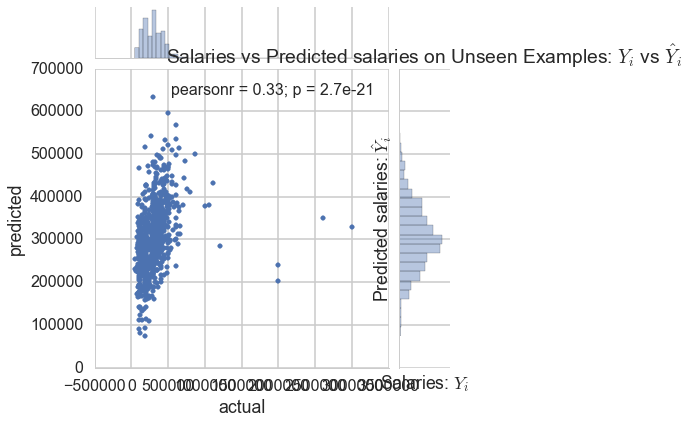

In [24]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_test)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Unseen Examples: $Y_i$ vs $\hat{Y}_i$");

## Cross validation score

In [25]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 54963886313.762962
combined score: 54963886313.762962 
score: 6220370355358.506836
combined score: 6220370355358.506836 
score: 31265752142.801918
combined score: 31265752142.801918 
score: 29386919449.676483
combined score: 29386919449.676483 
score: 68734123348.896225
combined score: 68734123348.896225 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [26]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 1.28094420732e+12, std: 2.46975721856e+12 


In [27]:
mseTrain = np.mean((y_train - pipeline.predict(X_train)) ** 2)
mseTest = np.mean((y_test - pipeline.predict(X_test)) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 39093794580.703598 
Mean Squared Error on unseen examples 39360983714.936951 


## Submission

In [28]:
# train on full data
pipeline.fit(X, y)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001C95F278>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [29]:
submission = pd.read_excel('data/submission.xlsx')

In [31]:
# predictions
test = test[test.columns.drop('salary')]
preds = pipeline.predict(test)

In [33]:
submission['Salary'] = preds

In [35]:
submission.to_excel('submissions/first_submission.xls', index=False)

## Lasso Regression

In [28]:
ft = FeatureTransformer(train, test)
sel = SelectKBest(f_regression, k=10)
scaler = StandardScaler()
lasso = Lasso(alpha=0.5)

In [29]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('lasso', lasso)])

In [30]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001C4BC278>)), ('lasso', Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [31]:
lasso_comp = pipeline.get_params()['lasso']

In [32]:
print 'Estimated intercept coefficient:', lasso_comp.intercept_

Estimated intercept coefficient: 306946.216385


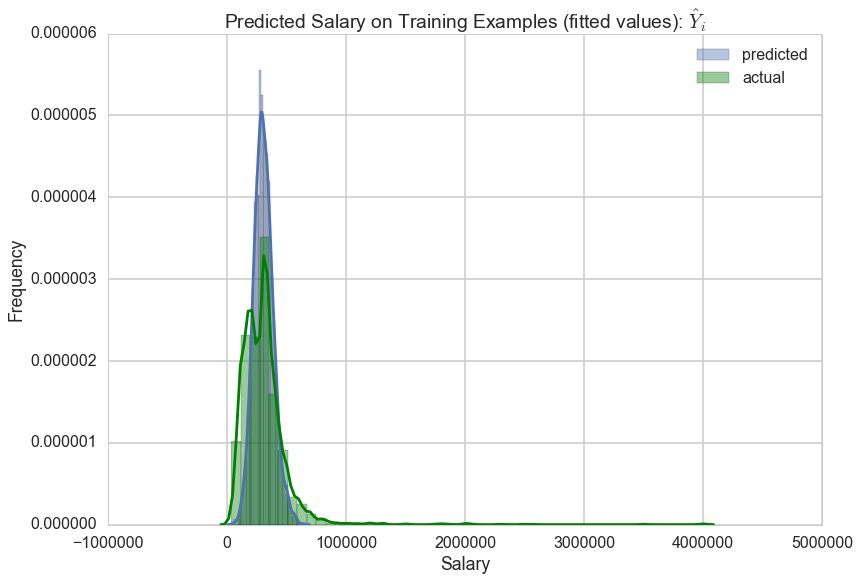

In [33]:
sns.distplot(pipeline.predict(X_train), label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

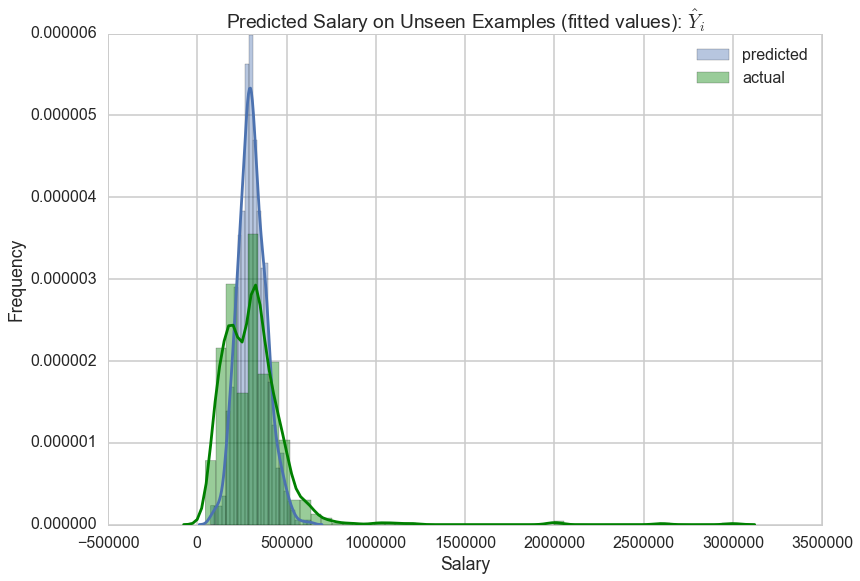

In [34]:
sns.distplot(pipeline.predict(X_test), label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [35]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 43611464173.363251
combined score: 43611464173.363251 
score: 34016268877.578644
combined score: 34016268877.578644 
score: 5540314733491.499023
combined score: 5540314733491.499023 
score: 71180757300.845551
combined score: 71180757300.845551 
score: 22290483584.064419
combined score: 22290483584.064419 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [36]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 1.14228274149e+12, std: 2.1990752907e+12 


In [37]:
mseTrain = np.mean((y_train - pipeline.predict(X_train)) ** 2)
mseTest = np.mean((y_test - pipeline.predict(X_test)) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 39042620433.980988 
Mean Squared Error on unseen examples 39344250843.514580 


## Ridge Regression

In [38]:
ft = FeatureTransformer(train, test)
sel = SelectKBest(f_regression, k=10)
scaler = StandardScaler()
ridge = Ridge()

In [39]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('ridge', ridge)])

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001C882198>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001))])

In [41]:
ridge_comp = pipeline.get_params()['ridge']

In [42]:
print 'Estimated intercept coefficient:', ridge_comp.intercept_

Estimated intercept coefficient: 306946.216385


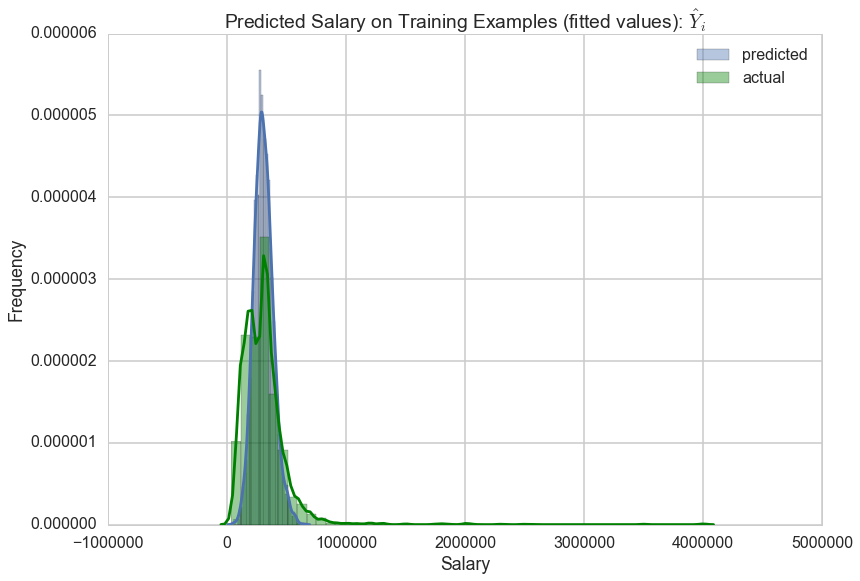

In [43]:
sns.distplot(pipeline.predict(X_train), label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

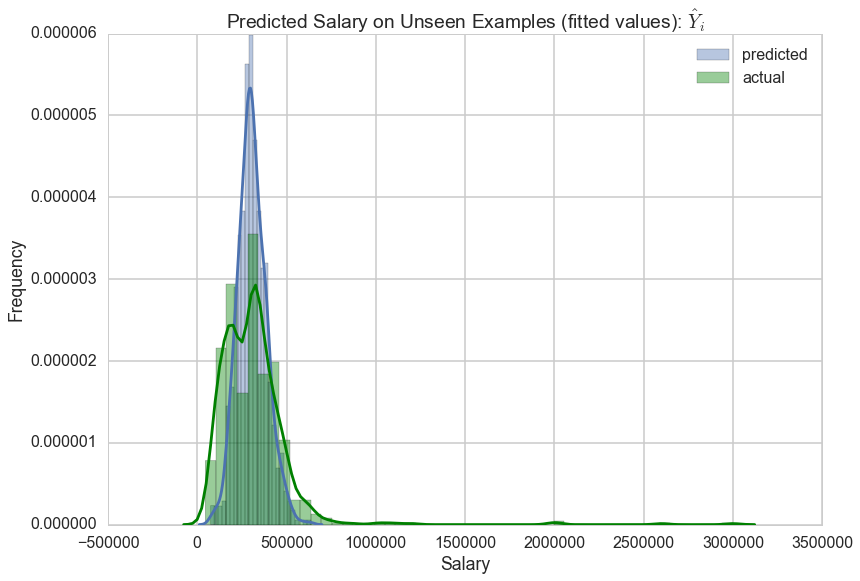

In [44]:
sns.distplot(pipeline.predict(X_test), label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [45]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 81363379686.295349
combined score: 81363379686.295349 
score: 47896902623.702736
combined score: 47896902623.702736 
score: 40357970664.258347
combined score: 40357970664.258347 
score: 6577252801214.862305
combined score: 6577252801214.862305 
score: 23773587249.415558
combined score: 23773587249.415558 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [46]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 1.35412892829e+12, std: 2.61162925014e+12 


In [47]:
mseTrain = np.mean((y_train - pipeline.predict(X_train)) ** 2)
mseTest = np.mean((y_test - pipeline.predict(X_test)) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 40055037184.255470 
Mean Squared Error on unseen examples 42430162976.514565 


## Random Forest Regression

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=20)
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [50]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('rf', rf)])

In [51]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=20, score_func=<function f_regression at 0x000000001C882198>)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,...mators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [52]:
rf_comp = pipeline.get_params()['rf']

In [53]:
# Feature Importance
feat_importances = pd.DataFrame(zip(feature_names, rf_comp.feature_importances_), columns = ['features', 'importance'])

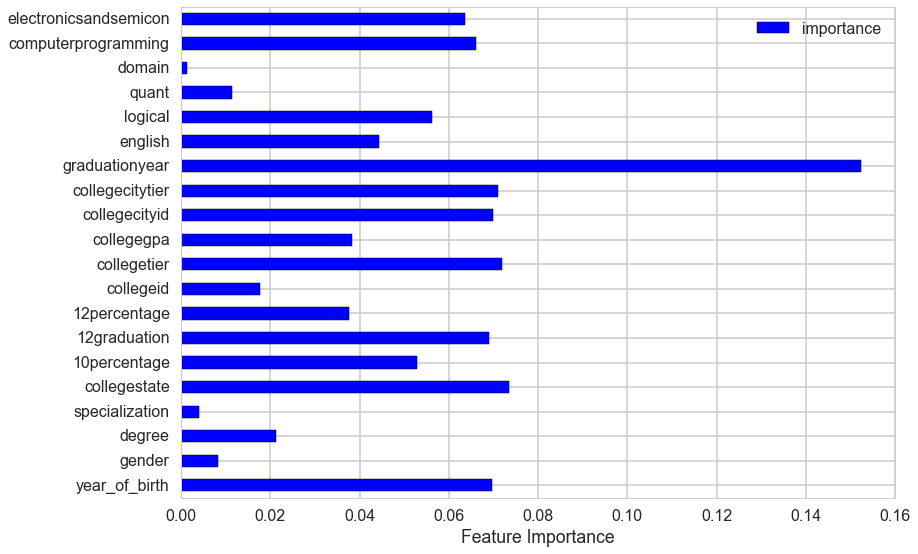

In [55]:
feat_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.yticks(feat_importances.index.values, feat_importances.features, rotation='horizontal');

In [56]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [57]:
# lets take a look at first five predicted values
predsTrain[0:5]

array([ 309900.,  209760.,  356190.,  334130.,  191220.])

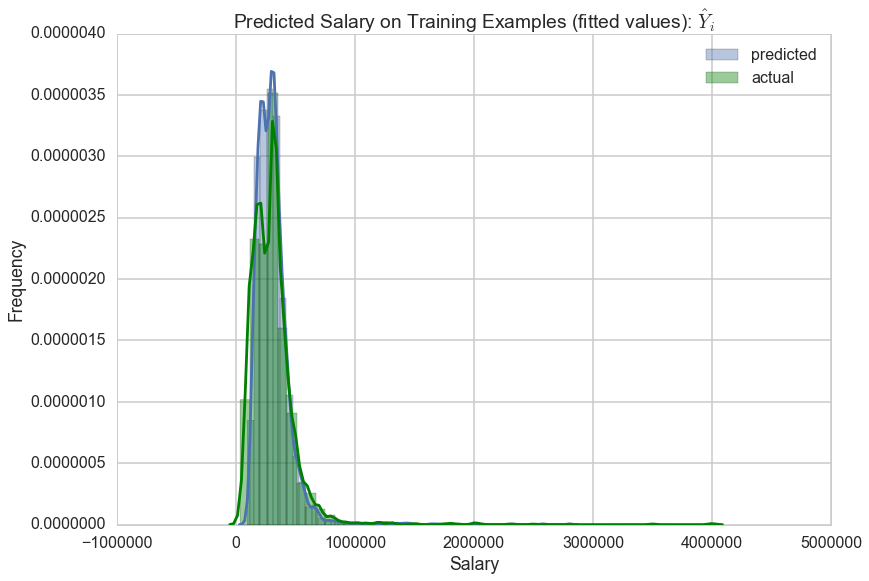

In [58]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

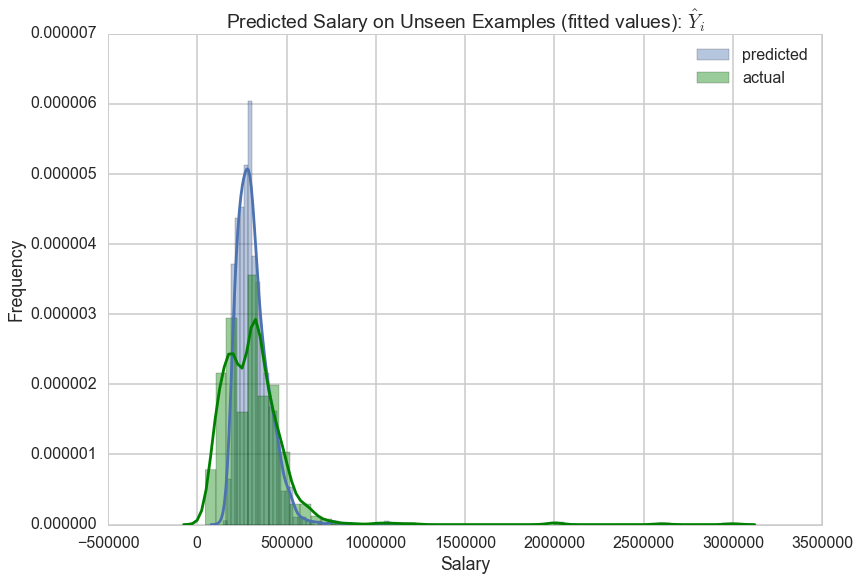

In [59]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [60]:
pred_comparison_train = pd.DataFrame(zip(y_train, predsTrain), columns=['actual', 'predicted'])

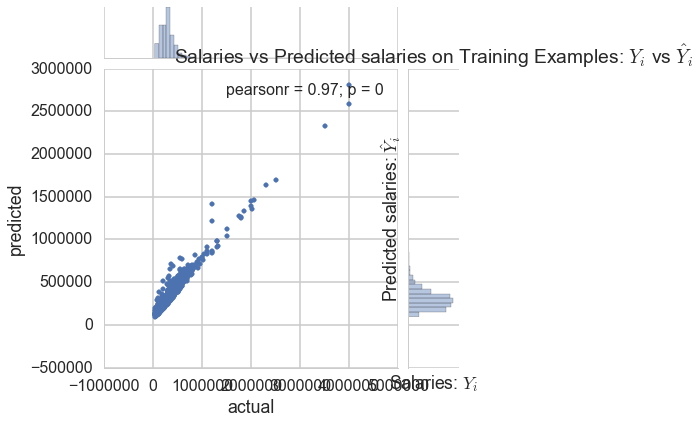

In [61]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_train)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Training Examples: $Y_i$ vs $\hat{Y}_i$");

In [62]:
pred_comparison_test = pd.DataFrame(zip(y_test, predsTest), columns=['actual', 'predicted'])

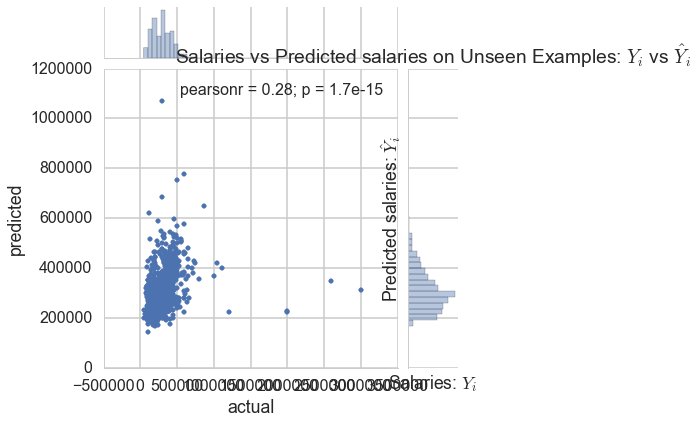

In [63]:
sns.jointplot(x='actual', y='predicted', data=pred_comparison_test)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries on Unseen Examples: $Y_i$ vs $\hat{Y}_i$");

## Cross validation scores

In [64]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 83176666694.131256
combined score: 83176666694.131256 
score: 52290333785.462502
combined score: 52290333785.462502 
score: 27130910818.906250
combined score: 27130910818.906250 
score: 76829695444.712494
combined score: 76829695444.712494 
score: 60360868002.656250
combined score: 60360868002.656250 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [65]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 59957694949.2, std: 19800675653.5 


In [66]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 5636788187.143214 
Mean Squared Error on unseen examples 41555298274.584999 


## Gradient Boosting Machines

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=20)
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, subsample=0.8)

In [ ]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('gbr', gbr)])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [ ]:
# lets take a look at first five predicted values
predsTrain[0:5]

In [ ]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [ ]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [ ]:
scores, mean = eval_models([pipeline], X_train, y_train)

In [ ]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

In [ ]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

## Linear SVM

In [67]:
from sklearn.svm import SVR

In [68]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=20)
svr = SVR(kernel='linear', C=50.0)

In [69]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('svr', svr)])

In [70]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=20, score_func=<function f_regression at 0x000000001C882198>)), ('svr', SVR(C=50.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [71]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [72]:
# lets take a look at first five predicted values
predsTrain[0:5]

array([ 308627.865609  ,  301467.44348527,  266766.83896204,
        367602.23967767,  207804.77848795])

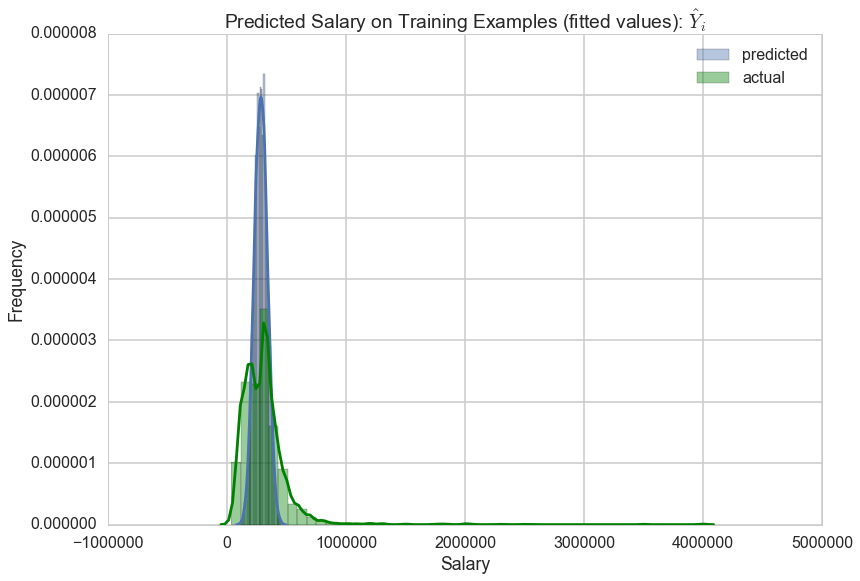

In [73]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

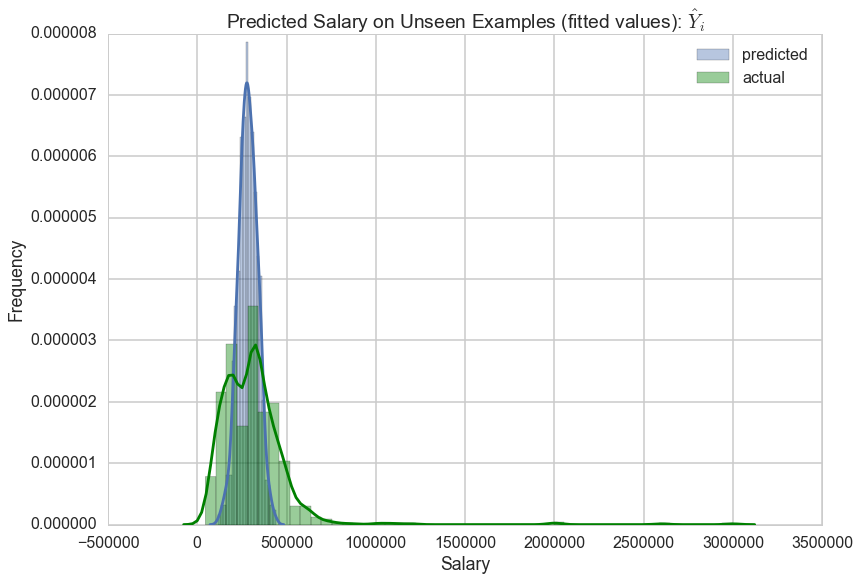

In [74]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [75]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 22461946424.792824
combined score: 22461946424.792824 
score: 577511267926.061157
combined score: 577511267926.061157 
score: 65865730745.497597
combined score: 65865730745.497597 
score: 47499716732.500801
combined score: 47499716732.500801 
score: 21906746717.307442
combined score: 21906746717.307442 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [76]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 1.47049081709e+11, std: 2.15861559611e+11 


In [77]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 40337589231.249901 
Mean Squared Error on unseen examples 40092017215.471497 


## KNN regression

In [79]:
from sklearn.neighbors import KNeighborsRegressor

In [120]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=10)
knr = KNeighborsRegressor(n_neighbors=20, weights='distance')

In [121]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('knr', knr)])

In [122]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=10, score_func=<function f_regression at 0x000000001C882198>)), ('knr', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=20, p=2, weights='distance'))])

In [123]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [124]:
# lets take a look at first five predicted values
predsTrain[0:5]

array([ 300000.,  100000.,  420000.,  300000.,  110000.])

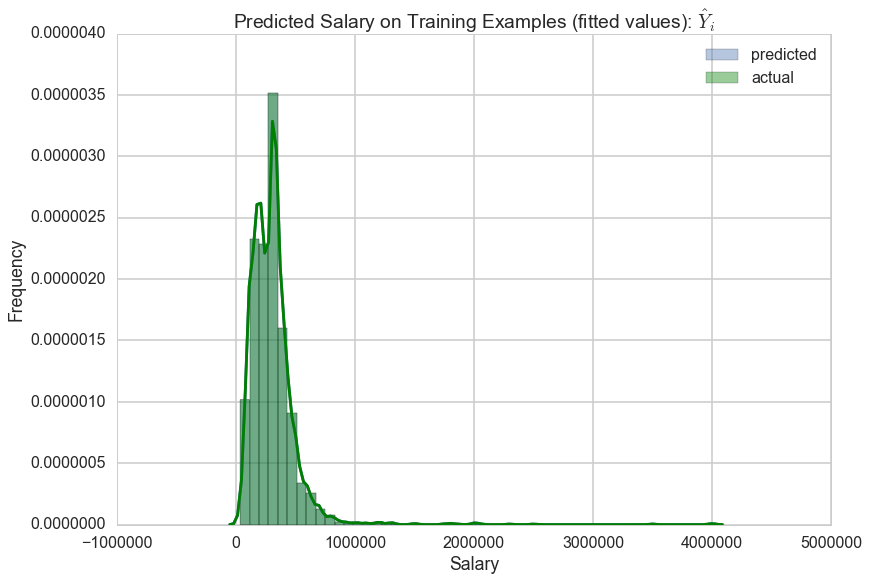

In [125]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

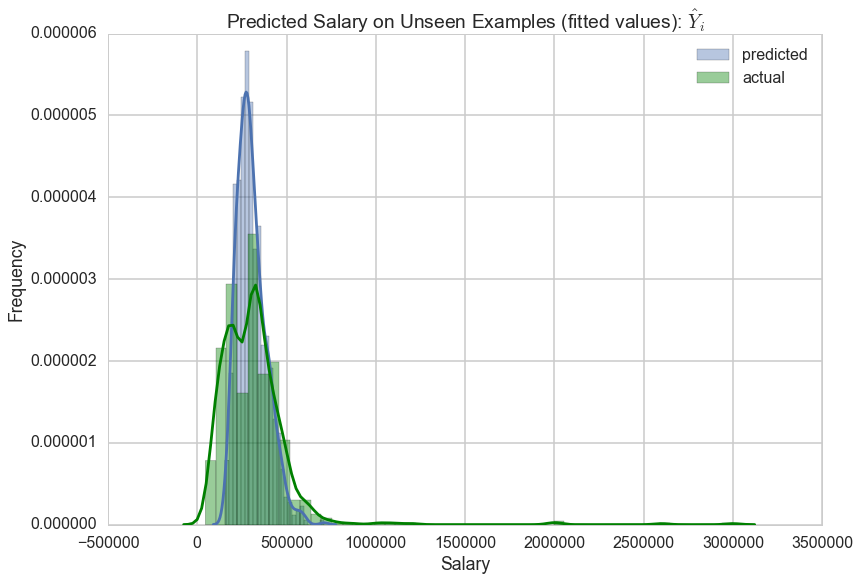

In [126]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [127]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 36847322929.776901
combined score: 36847322929.776901 
score: 52045261565.377792
combined score: 52045261565.377792 
score: 38616221183.228867
combined score: 38616221183.228867 
score: 55719031106.720825
combined score: 55719031106.720825 
score: 32758305956.432079
combined score: 32758305956.432079 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [128]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 43197228548.3, std: 9004013130.88 


In [129]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 0.000000 
Mean Squared Error on unseen examples 41518370818.947044 


** Till now linear regession is producing surprisingly best results, when all other models are over-predicting for most of the examples. **

## Extreme Gradient Boosting

In [38]:
import xgboost as xgb

In [39]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
sel = SelectKBest(f_regression, k=20)
xgbr = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, subsample=0.8, colsample_bytree=0.6, min_child_weight=5)

In [184]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('xgbr', xgbr)])

In [185]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sel', SelectKBest(k=20, score_func=<function f_regression at 0x000000001C882198>)), ('xgbr', XGBRegressor(base_score=0.5, colsample_bytree=0.6, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', seed=0, silent=True, subsample=0.8))])

In [186]:
predsTrain = pipeline.predict(X_train)
predsTest = pipeline.predict(X_test)

In [187]:
# lets take a look at first five predicted values
predsTrain[0:5]

array([ 295790.21875,  214570.78125,  289190.5625 ,  393241.375  ,
        196722.15625], dtype=float32)

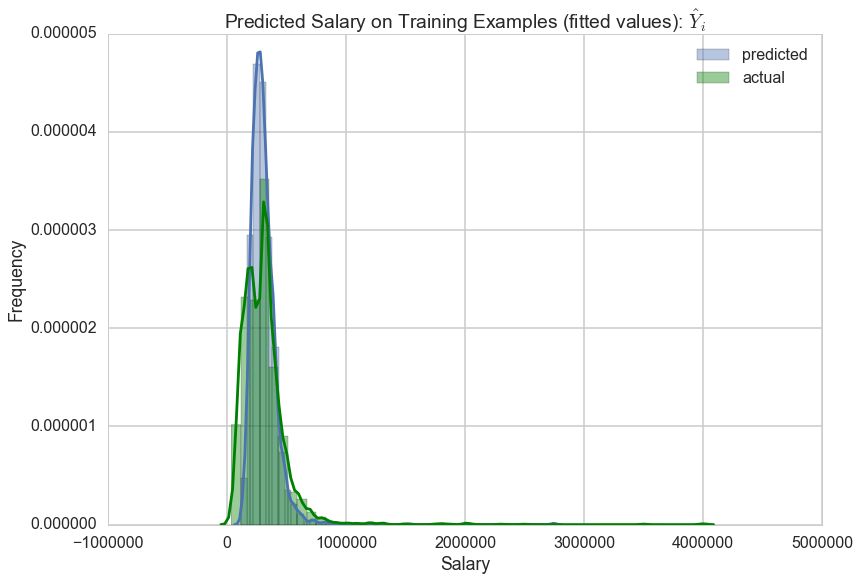

In [188]:
sns.distplot(predsTrain, label='predicted')
sns.distplot(y_train, color='g', label='actual')
plt.title('Predicted Salary on Training Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

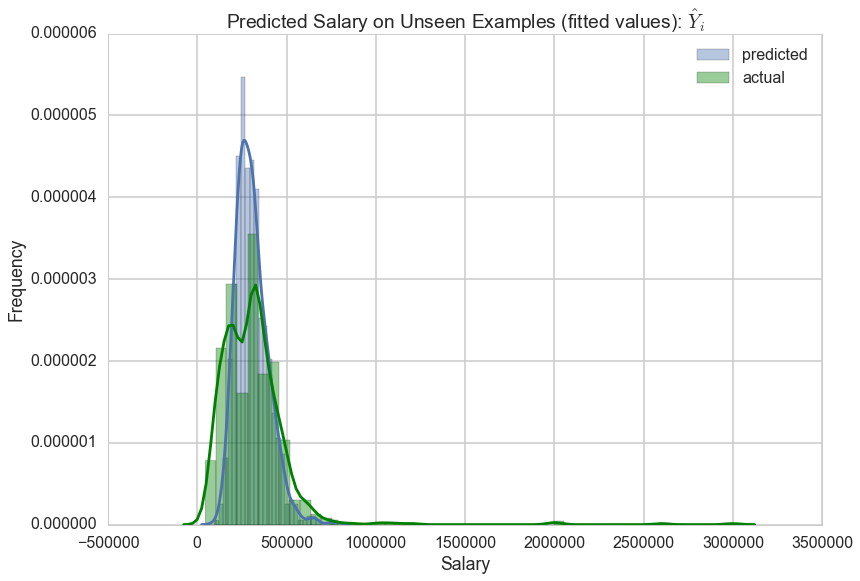

In [189]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Cross validation scores

In [190]:
scores, mean = eval_models([pipeline], X_train, y_train)

score: 59054683886.671974
combined score: 59054683886.671974 
score: 32499922504.503349
combined score: 32499922504.503349 
score: 47264501033.224899
combined score: 47264501033.224899 
score: 38824250497.102646
combined score: 38824250497.102646 
score: 52554977718.600388
combined score: 52554977718.600388 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


In [191]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 46039667128.0, std: 9473405649.95 


In [192]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 20724126056.752090 
Mean Squared Error on unseen examples 40616722095.299759 


## Ensemble of models

In [55]:
pipeline_lasso = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('lasso', lasso)])
# pipeline_xgbr = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('xgbr', xgbr)])
# pipeline_knr = Pipeline([('transformer', ft), ('scaler', scaler), ('sel', sel), ('knr', knr)])
pipeline_nnet = Pipeline([('transformer', ft), ('scaler', scaler), ('net', net)])

In [54]:
# Cross validation scores
scores, mean = eval_models([pipeline_lm, pipeline_nnet], X_train, y_train)

NameError: name 'pipeline_knr' is not defined

In [195]:
print 'Mean cv score: {}, std: {} '.format(scores, mean)

Mean cv score: 1.65161469235e+11, std: 2.48525960535e+11 


In [196]:
predsTrain = (pipeline_lm.predict(X_train) + pipeline_knr.predict(X_train)) / 2.
predsTest = (pipeline_lm.predict(X_test) + pipeline_knr.predict(X_test)) / 2.

In [197]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 17748155084.374786 
Mean Squared Error on unseen examples 38980961384.790321 


## Neural Networks

In [40]:
from nolearn.lasagne import NeuralNet

from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer

from lasagne.updates import nesterov_momentum

In [41]:
y_train_log = np.log1p(y_train)

In [42]:
layers = [('input', InputLayer),
           ('hidden_0', DenseLayer),
           ('hidden_1', DenseLayer),
           ('output', DenseLayer)]

In [43]:
ft = FeatureTransformer(train, test)
scaler = StandardScaler()
net = NeuralNet(layers=layers,
                 
                 # layer parameters:
                input_shape=(None, 107),
                hidden_0_num_units=10,  # number of units in hidden layer
                hidden_1_num_units=5,
                output_nonlinearity=None,  # output layer uses identity function
                output_num_units=1,  # 1 target value

                # optimization method:
                update=nesterov_momentum,
                update_learning_rate=.01,
                update_momentum=0.9,

                regression=True,  # flag to indicate we're dealing with regression problem
                max_epochs=75,  # we want to train this many epochs
                verbose=1)

In [44]:
pipeline = Pipeline([('transformer', ft), ('scaler', scaler), ('net', net)])

In [45]:
pipeline.fit(X_train, y_train_log)

# Neural Network with 1141 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input        107
  1  hidden_0      10
  2  hidden_1       5
  3  output         1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1      21.98533       1.83344     11.99127  0.02s
      2       0.53767       0.30053      1.78909  0.02s
      3       0.36023       0.27957      1.28851  0.02s
      4       0.29224       0.27641      1.05726  0.05s
      5       0.31737       0.27510      1.15364  0.02s
      6       0.28159       0.27327      1.03043  0.02s
      7       0.29075       0.26900      1.08088  0.03s
      8       0.27655       0.26876      1.02899  0.03s
      9       0.27887       0.26525      1.05132  0.02s
     10       0.27261       0.26502      1.02864  0.02s
     11       0.27342       0.26274      1.04064  0.03s
     12       0.26933       0.26238      1.02648  0.03s
     13       

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('net', NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000000001FA69978>,
     batch_iterator_train=<nolear...ntum=0.9,
     use_label_encoder=False, verbose=1,
     y_tensor_type=TensorType(float64, matrix)))])

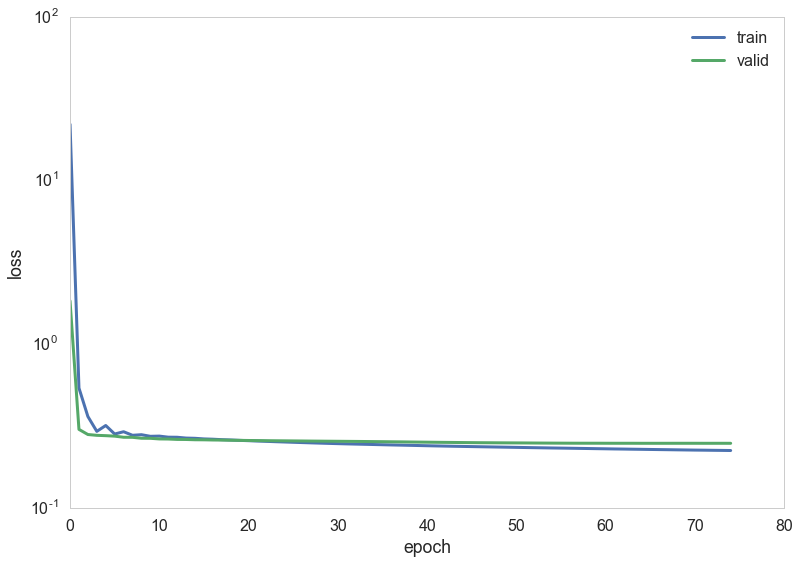

In [49]:
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.show();

In [50]:
predsTrain = np.expm1(pipeline.predict(X_train)).reshape(-1,)
predsTest = np.expm1(pipeline.predict(X_test)).reshape(-1,)

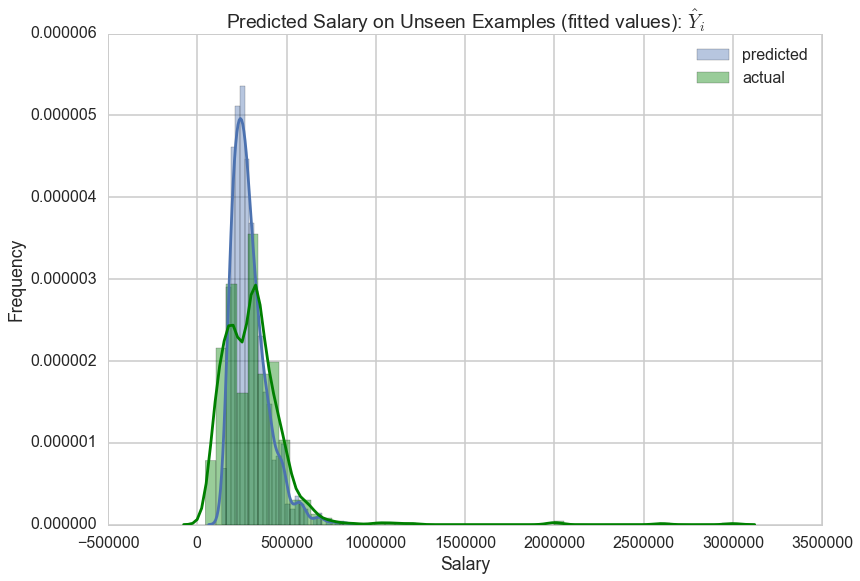

In [51]:
sns.distplot(predsTest, label='predicted')
sns.distplot(y_test, color='g', label='actual')
plt.title('Predicted Salary on Unseen Examples (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [52]:
mseTrain = np.mean((y_train - predsTrain) ** 2)
mseTest = np.mean((y_test - predsTest) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 37656891261.908653 
Mean Squared Error on unseen examples 43147597227.142418 


In [56]:
pipeline_lasso.fit(X_train, y_train)
pipeline_nnet.fit(X_train, y_train_log)

     76       0.22298       0.24706      0.90252  0.02s
     77       0.22262       0.24710      0.90093  0.02s
     78       0.22226       0.24708      0.89954  0.02s
     79       0.22196       0.24706      0.89842  0.02s
     80       0.22166       0.24712      0.89696  0.02s
     81       0.22131       0.24708      0.89570  0.04s
     82       0.22103       0.24714      0.89436  0.02s
     83       0.22070       0.24709      0.89320  0.02s
     84       0.22042       0.24695      0.89254  0.03s
     85       0.22010       0.24689      0.89153  0.04s
     86       0.21981       0.24683      0.89054  0.02s
     87       0.21952       0.24680      0.88946  0.02s
     88       0.21929       0.24675      0.88871  0.02s
     89       0.21894       0.24675      0.88730  0.03s
     90       0.21867       0.24674      0.88624  0.02s
     91       0.21840       0.24680      0.88491  0.02s
     92       0.21810       0.24690      0.88336  0.02s
     93       0.21782       0.24699      0.88191

Pipeline(steps=[('transformer', FeatureTransformer(test=None, train=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('net', NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000000001FA69978>,
     batch_iterator_train=<nolear...ntum=0.9,
     use_label_encoder=False, verbose=1,
     y_tensor_type=TensorType(float64, matrix)))])

In [57]:
predsTrain_lasso = pipeline_lasso.predict(X_train)
predsTrain_nnet = np.expm1(pipeline_nnet.predict(X_train).reshape(-1,))

predsTest_lasso = pipeline_lasso.predict(X_test)
predsTest_nnet = np.expm1(pipeline_nnet.predict(X_test).reshape(-1,))

In [58]:
avg_preds_train = (predsTrain_lasso + predsTrain_nnet) / 2.
avg_preds_test = (predsTest_lasso + predsTest_nnet) / 2.

In [59]:
mseTrain = np.mean((y_train - avg_preds_train) ** 2)
mseTest = np.mean((y_test - avg_preds_test) ** 2)

print 'Mean Squared Error on training examples %f ' %mseTrain
print 'Mean Squared Error on unseen examples %f ' %mseTest

Mean Squared Error on training examples 35724699830.428223 
Mean Squared Error on unseen examples 40503125013.666550 
